In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 15,
            'per_task_examples': np.inf,
            # 'per_task_examples': 1000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:1' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.01,
            'metric' : "DP",
            'lambda': 0.5,
            'lambda_old': 0.0,
            
              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=1_epoch=15_lr=0.001_tau=10.0_alpha=0.01_lmbd_0.5_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
benchmark.mnist_train.sensitives

array([5, 0, 4, ..., 5, 6, 8])

In [5]:
from torchvision.transforms.functional import to_pil_image
from cl_gym.benchmarks.transforms import MNIST_MEAN, MNIST_STD
COLOR_MAP = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (1, 1, 0),
    3: (0, 0, 1),
    4: (1, 0.65, 0),
    5: (0.5, 0, 0.5),
    6: (0, 1, 1),
    7: (1, 0.75, 0.8),
    8: (0.8, 1, 0),
    9: (.588, .294, 0.)
}

r = (1 - 0.1913)
color_values = np.array(list(COLOR_MAP.values()))
m_rgb = color_values.mean(axis=0)
std_rgb = color_values.std(axis=0)

bmnist_mean = [r*m + MNIST_MEAN[0] for m in m_rgb]
bmnist_std = [(r*s**2+(1-r)*MNIST_STD[0]**2+r*(1-r)*(bmnist_mean[i] - m_rgb[i])**2)**0.5 for i, s in enumerate(std_rgb)]

unnormalize = torchvision.transforms.Normalize([-m/s for m, s in zip(bmnist_mean, bmnist_std)], [1/s for s in bmnist_std])
sample_idx = 95
to_pil_image(unnormalize(benchmark.trains[2][sample_idx][0]), mode="RGB")

In [6]:
target_label = 0
incremental_step = 1
# cat_img = torch.cat([img for img in benchmark.trains[incremental_step].inputs[benchmark.trains[incremental_step].targets == target_label][20:30]], dim=2)
cat_img = torch.cat([img for img, target, *_ in benchmark.tests[incremental_step]][20:30], dim=2)
to_pil_image(unnormalize(cat_img), mode="RGB")

In [7]:
from trainers import FairContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector
from metrics import MetricCollector2

from algorithms import Heuristic3
from algorithms.fairl import FaIRL
from algorithms.icarl import iCaRL
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
# backbone = ResNet18Small2(
#         input_dim=input_dim, 
#         output_dim=num_classes,
#         class_idx=class_idx,
#         config=params
#     ).to(params['device'])
# algorithm = iCaRL(backbone, benchmark, params, requires_memory=True)
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])
# metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
#                                                         eval_interval='epoch',
#                                                         epochs_per_task=params['epochs_per_task'])
from trainers.baselines import BaseMemoryContinualTrainer as ContinualTrainer

# trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [8]:
algorithm.params['dataset'] == "BiasedMNIST"

True

In [9]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------


[1] Eval metrics for task 1 >> {'accuracy': 0.812065090353322, 'loss': 0.0022577903935813454, 'std': 0.061404297401780106, 'EER': -1, 'EO': [0.24750499001996007, 0.4956217162872154], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6284366468464122, 'classwise_accuracy': {0: array([856, 980]), 1: array([ 852, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 479, 1: 564}, 'class_pred_count_s1': {1: 412, 0: 660}, 'class_pred_count': {0: 1139, 1: 976}, 'count_s0': 1043, 'count_s1': 1072, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.8797514159848961, 'loss': 0.0013401257230880412, 'std': 0.055962869729389575, 'EER': -1, 'EO': [0.350262697022767, 0.12574850299401197], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.7619943999916106, 'classwise_accuracy': {1: array([ 935, 1135]), 0: array([917, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 564, 0: 479}, 'class_pred_count_s1': {1: 434, 0: 638}, 'class_pred_count': {1: 998, 0: 1117}, 'count_s0': 1043, 'count_s1': 10

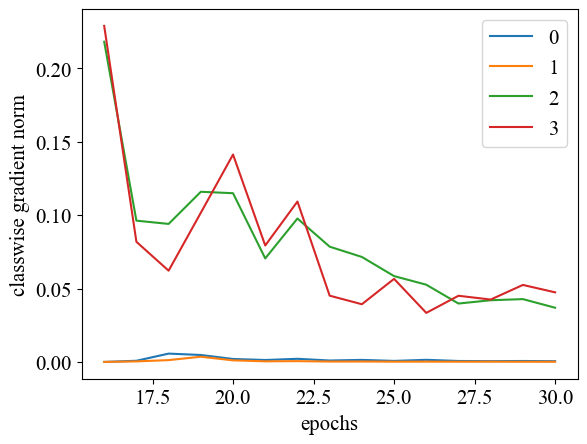

---------------------------- Task 3 -----------------------
losses=tensor([[9.6401e-04, 3.7844e-04, 1.4375e-01, 1.0201e-01, 1.2055e+01, 1.0319e+01,
         6.6740e-03, 1.1259e-02, 5.3147e-01, 2.2421e-01, 1.1411e+01, 1.1641e+01]])
Elapsed time(grad):5.655
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):7.276
Fairness:[ 0.00101279 -0.00166064  0.          0.00333809 -0.00359193  0.01181696]
Current class expected loss:tensor([[ 3.1305, -1.6332, -1.9529,  2.1826,  0.2201, -0.7876,  3.0283, -1.7470,
         -2.0430,  2.6935, -0.2201,  0.7876]])
len(updated_seq_indices)=2432
Elapsed time(etc):0.221
temporal training...
temporal training done
[31] Eval metrics for task 1 >> {'accuracy': 0.9168210015283647, 'loss': 0.0013083673397136354, 'std': 0.01886181785489527, 'EER': -1, 'EO': [0.1102240687607905, 0.17101496380933334], 'DP': -1, 'accuracy_s0': 0.9882604865337065, 'accuracy_s1': 0.8476409702486445, 'classwise_accuracy': {1: array([1062, 1135]), 0: array([880,

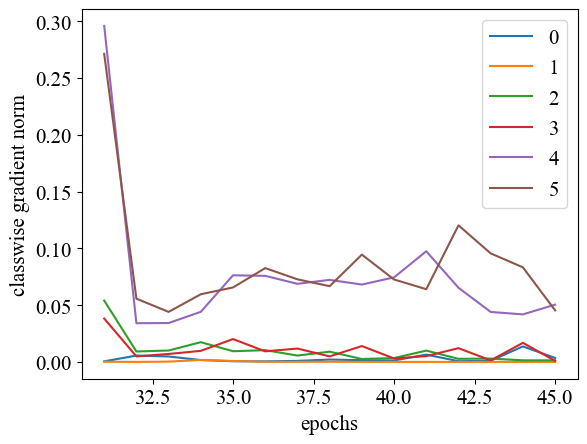

---------------------------- Task 4 -----------------------
losses=tensor([[3.0162e-03, 3.4838e-05, 2.1681e-02, 6.4181e-04, 3.3697e-01, 1.8123e-01,
         1.2489e+01, 7.1408e+00, 8.2838e-03, 1.8726e-02, 5.0832e-02, 4.9863e-02,
         7.7858e-01, 8.6118e-01, 1.1460e+01, 9.8016e+00]])
Elapsed time(grad):5.08
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.547
Fairness:[-1.35525272e-20  0.00000000e+00  1.37095295e-03 -5.45891793e-04
  3.17535300e-03  3.45549263e-03  0.00000000e+00  2.20664944e-02]
Current class expected loss:tensor([[-1.6767e-01, -6.3632e-01,  7.1382e-01, -2.8359e-01,  3.2812e-01,
          3.2955e-01, -9.5367e-07, -1.7426e+00, -1.5603e-01, -6.1389e-01,
          9.7736e-01, -3.8605e-01,  8.3965e-01,  9.4875e-01,  0.0000e+00,
          1.7426e+00]])
len(updated_seq_indices)=2432
Elapsed time(etc):0.199
temporal training...
temporal training done
[46] Eval metrics for task 1 >> {'accuracy': 0.9138788995774522, 'loss': 0.001374963700912241

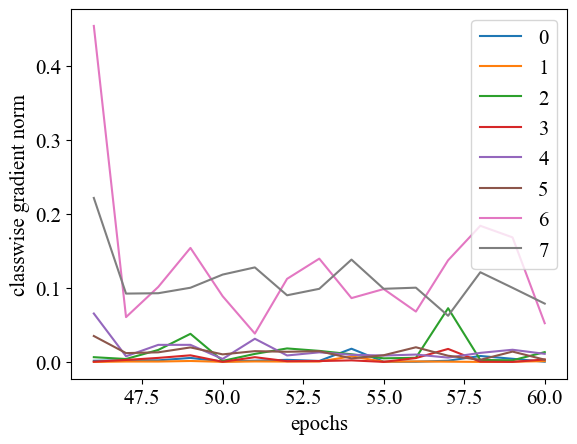

---------------------------- Task 5 -----------------------
losses=tensor([[1.3550e-03, 1.2112e-03, 3.1349e-02, 1.5501e-02, 3.6521e-02, 2.1128e-02,
         2.7690e-01, 6.6522e-01, 1.0735e+01, 1.1708e+01, 1.3094e-02, 1.0594e-01,
         5.5900e-02, 2.4964e-01, 1.9566e-01, 1.0136e-01, 7.0225e-01, 5.4386e-01,
         1.0598e+01, 9.9241e+00]])
Elapsed time(grad):3.106
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):12.389
Fairness:[-6.41366985e-04  0.00000000e+00 -2.65213477e-04  0.00000000e+00
  1.48150471e-03  1.94784385e-03  0.00000000e+00 -9.34712351e-04
  4.33680869e-19 -8.12187278e-03]
Current class expected loss:tensor([[-4.7477e-01, -1.8320e+00,  1.8083e+00, -2.0208e+00,  9.5517e-01,
          1.5249e+00, -8.2915e-01,  8.8702e-01, -2.8610e-06,  8.0965e-01,
         -5.6318e-01, -1.7674e+00,  1.8360e+00, -2.1149e+00,  1.2440e+00,
          1.9716e+00, -7.8971e-01,  7.5854e-01,  0.0000e+00, -8.0965e-01]])
len(updated_seq_indices)=2752
Elapsed time(etc):

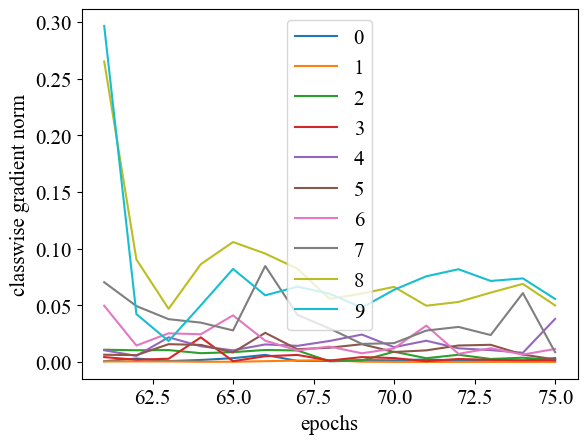

final avg-acc 0.8234857746964538
final avg-forget 0.08275401078776323


In [10]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [11]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")

61.6106	74.2933	71.6381	66.4136	
96.8361	114.6091	166.8694	177.5764	
3.6285	3.6653	3.2421	4.0786	
290.8116	294.1923	325.708	376.7986	

In [12]:
num_class_per_task = 2
num_epochs = params['epochs_per_task']

t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = list()
    groupwise_expected_loss[i] = list()
    for j in range(2):
        groupwise_true_loss[i].append(dict())
        groupwise_expected_loss[i].append(dict())


for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            if i < num_class_per_task*task:
                groupwise_true_loss[i][0][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i][0][(task-1)*num_epochs+epoch] = el
            else:
                groupwise_true_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = el

            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


In [13]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][0][ce], end='\t')
    print()


0.0001	0.0109	0.0519	0.0474	0.0202	0.0102	0.0119	0.0089	0.0074	0.0034	0.0056	0.0025	0.002	0.0023	0.0016	0.0633	0.028	0.0178	0.0042	0.0015	0.0014	0.0028	0.0055	0.0044	0.0048	0.0162	0.0023	0.0042	0.044	0.008	0.0027	0.0042	0.006	0.0335	0.0014	0.0029	0.006	0.006	0.022	0.0005	0.0005	0.0025	0.0162	0.007	0.0006	0.009	0.0047	0.0035	0.005	0.008	0.0241	0.0037	0.0035	0.0049	0.0045	0.0068	0.0039	0.002	0.0025	0.0056	
0.0001	0.0023	0.0071	0.0217	0.0091	0.0025	0.0042	0.0013	0.0013	0.0008	0.0007	0.0005	0.0006	0.0004	0.0004	0.0005	0.0001	0.0007	0.0048	0.0025	0.0004	0.0002	0.0004	0.0001	0.0001	0.0001	0.0	0.0001	0.0	0.0	0.0	0.0021	0.0019	0.0071	0.0007	0.0014	0.0021	0.0067	0.0196	0.0008	0.0013	0.0005	0.0002	0.0008	0.0022	0.0013	0.0023	0.0017	0.0009	0.0013	0.0032	0.0045	0.0047	0.0009	0.0003	0.0003	0.0003	0.0004	0.0004	0.0004	
3.1683	0.6341	0.5953	0.6181	0.4437	0.249	0.2878	0.2048	0.1936	0.167	0.1345	0.1177	0.1111	0.1142	0.1098	0.3637	0.1667	0.2016	0.1665	0.087	0.0862	0.0532	0.0525	0.0232	0.0279	0.0529	0.01

In [14]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][1][ce], end='\t')
    print()


0.1427	0.1305	0.2549	0.2693	0.1489	0.0722	0.091	0.044	0.0407	0.0353	0.0292	0.0227	0.0181	0.0143	0.0137	0.0523	0.0676	0.0426	0.0457	0.03	0.0142	0.025	0.0216	0.0267	0.0235	0.0501	0.0087	0.0076	0.0437	0.0372	0.0901	0.0516	0.0332	0.0418	0.0145	0.0219	0.0175	0.0261	0.0302	0.1484	0.0437	0.0497	0.4349	0.0402	0.0197	0.025	0.0222	0.0491	0.1248	0.017	0.0633	0.0354	0.0583	0.0225	0.0341	0.0914	0.0335	0.0273	0.0108	0.008	
0.1251	0.1048	0.0623	0.078	0.0738	0.1113	0.2305	0.1155	0.0958	0.0718	0.0535	0.0481	0.0384	0.0365	0.0316	0.013	0.0826	0.0645	0.069	0.0722	0.0461	0.0582	0.0296	0.0254	0.0159	0.0355	0.0366	0.0125	0.0823	0.0121	0.0826	0.1039	0.0844	0.0584	0.0575	0.1751	0.1313	0.0691	0.3432	0.2055	0.1415	0.1668	0.0313	0.1189	0.0712	0.0942	0.0517	0.0562	0.0306	0.189	0.0304	0.0854	0.0401	0.1721	0.0769	0.0112	0.0336	0.0197	0.0369	0.0221	
4.3915	2.0915	1.6844	1.2622	1.0815	1.0399	0.8213	0.7505	0.6799	0.5363	0.5146	0.4322	0.3995	0.3652	0.3619	0.6601	0.3265	0.4633	0.3133	0.2624	0.2213	0.1556	0.1616	0.0875	0.

In [15]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][0][ce], end='\t')
    print()


0.8089	2.2458	2.0767	2.3555	2.0556	1.8597	1.302	1.8662	1.2596	1.0887	1.0271	1.0323	1.0509	1.1185	1.0694	3.1305	1.0076	0.8391	0.5688	0.5349	0.7771	0.7324	0.6227	0.7872	0.9443	0.7306	0.8217	0.7894	1.1996	0.6516	-0.1677	-0.3203	-0.025	0.0747	-0.1485	0.0972	0.0429	0.1995	-0.0259	-0.0	0.2495	0.9582	-0.0467	-0.1506	0.1347	-0.4748	-0.45	0.2008	0.0267	-0.0957	0.3974	0.1234	0.143	0.203	0.07	0.2907	0.3592	0.2437	0.0186	-0.0802	
0.6078	1.082	1.0444	1.139	1.3936	1.3304	2.0175	1.1589	1.459	1.2131	1.091	0.8529	0.7457	0.6182	0.5261	-1.6332	-0.3877	-0.1196	-0.0161	0.1822	0.3477	0.2999	0.266	0.2811	0.4232	0.1556	0.0751	0.3098	0.3002	0.2279	-0.6363	0.35	0.5719	0.6147	0.6695	0.8595	0.4404	1.0895	1.4659	0.2128	0.4322	0.4271	0.5714	0.447	0.5569	-1.832	0.2033	0.3862	0.309	0.1468	0.3485	0.2429	0.2553	0.2095	0.1842	0.09	0.1512	0.2187	0.2883	0.1522	
-0.1423	-0.6754	-0.375	-0.0	-0.0	-0.0889	-0.0	-0.0693	-0.0621	-0.0751	-0.1414	-0.095	-0.0815	-0.0484	-0.0793	-1.9529	1.856	1.5772	1.2709	1.2024	1.075	1.1959	0.7918

In [16]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][1][ce], end='\t')
    print()


0.7527	2.288	2.2657	2.5896	2.1467	1.8758	1.3851	1.9297	1.3193	1.181	1.0922	1.0959	1.1006	1.1706	1.1208	3.0283	0.6491	0.8259	0.5293	0.4977	0.7232	0.6816	0.5795	0.6315	0.869	0.6799	0.8031	0.8008	1.1655	0.6243	-0.156	0.3	0.2504	0.0695	0.1648	0.1594	0.0399	0.1857	0.1108	0.3794	0.2072	0.7541	0.7821	-0.0595	0.4769	-0.5632	-0.2049	0.1868	0.0589	0.0872	0.1861	0.1008	0.133	0.1889	0.045	0.2705	0.2895	0.2306	0.0173	0.054	
0.5864	1.1284	1.1893	1.2735	1.6288	1.6541	2.5012	1.5083	1.7445	1.5196	1.3379	1.0764	0.9352	0.7393	0.6124	-1.747	-0.3121	-0.0964	-0.0333	-0.1764	-0.0294	-0.1688	-0.0904	-0.2106	-0.0631	-0.2974	-0.2423	-0.0534	0.0344	-0.0347	-0.6139	0.434	0.489	0.7141	0.2526	0.8292	0.4249	0.9793	1.4142	0.3809	0.417	0.5851	0.0817	0.2646	0.5373	-1.7674	0.0943	0.1139	0.1925	0.2187	0.3362	0.1416	0.207	0.0528	-0.0034	-0.0401	-0.0693	-0.0472	0.0982	-0.1458	
0.1423	0.6754	0.375	-0.0	0.0	0.0889	-0.0	0.0693	0.0621	0.0751	0.1414	0.095	0.0815	0.0484	0.0793	-2.043	1.9417	1.65	1.3296	1.2579	1.1246	1.2511	0.829

In [17]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"DP:{np.mean(metric_manager_callback.meters['DP'].compute_overall())}")
print(f"EO:{np.mean(metric_manager_callback.meters['EO'].compute_overall())}")


accuracy:0.8923227192825529
DP:0.006398233752447013
EO:0.13177185081927395
